In [93]:
import pickle
import numpy as np
import pandas as pd
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from math import trunc
from skmultiflow.trees import RegressionHoeffdingTree, RegressionHAT, HoeffdingTree
import copy
import random
from skmultiflow.evaluation import EvaluatePrequential
%matplotlib inline

## Test Implementation

In [194]:
n_samples, n_features = 10, 5
np.random.seed(0)
y = np.random.randn(n_samples)
X = np.random.randn(n_samples, n_features)

In [197]:
X

array([[ 0.14404357,  1.45427351,  0.76103773,  0.12167502,  0.44386323],
       [ 0.33367433,  1.49407907, -0.20515826,  0.3130677 , -0.85409574],
       [-2.55298982,  0.6536186 ,  0.8644362 , -0.74216502,  2.26975462],
       [-1.45436567,  0.04575852, -0.18718385,  1.53277921,  1.46935877],
       [ 0.15494743,  0.37816252, -0.88778575, -1.98079647, -0.34791215],
       [ 0.15634897,  1.23029068,  1.20237985, -0.38732682, -0.30230275],
       [-1.04855297, -1.42001794, -1.70627019,  1.9507754 , -0.50965218],
       [-0.4380743 , -1.25279536,  0.77749036, -1.61389785, -0.21274028],
       [-0.89546656,  0.3869025 , -0.51080514, -1.18063218, -0.02818223],
       [ 0.42833187,  0.06651722,  0.3024719 , -0.63432209, -0.36274117]])

Text(0.5, 0, 'Instance')

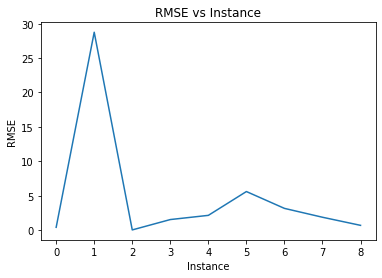

In [187]:
rhat = RegressionHAT()
rmseList = list()
for instanceIndex in range(0, len(X)):
    instance = X[instanceIndex].reshape(1, -1)
    label = y[instanceIndex].reshape(-1, 1)
    if instanceIndex == 0:
        #train the model
        rhat.fit(instance,label)
    else:
        #test the model
        predicted = rhat.predict(instance)
        #get rmse
        rmse = np.sqrt(metrics.mean_squared_error(label, predicted))
        rmseList.append(rmse)
        #train the model on the new point
        rhat.fit(instance,label)

plt.figure()
plt.plot(rmseList)
plt.title('RMSE vs Instance')
plt.ylabel('RMSE')
plt.xlabel('Instance')

Text(0.5, 0, 'Instance')

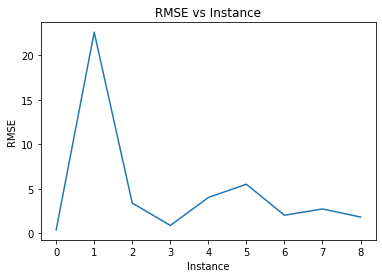

In [142]:
rht = RegressionHoeffdingTree()
rmseList = list()
for instanceIndex in range(0, len(X)):
    instance = X[instanceIndex].reshape(1, -1)
    label = y[instanceIndex].reshape(-1, 1)
    if instanceIndex == 0:
        #train the model
        rht.fit(instance,label)
    else:
        #test the model
        predicted = rht.predict(instance)
        #get rmse
        rmse = np.sqrt(metrics.mean_squared_error(label, predicted))
        rmseList.append(rmse)
        #train the model on the new point
        rht.fit(instance,label)

plt.figure()
plt.plot(rmseList)
plt.title('RMSE vs Instance')
plt.ylabel('RMSE')
plt.xlabel('Instance')

## SOF Implementation

In [31]:
#label (VOC) dataframe
def generateVOCScreenings(vocDf2013,vocDf2015, sliceDf, matchedMovies):
    screeningList = list()
    prevStartIndex = 0
    startIndex = 0
    vocDf = vocDf2013
    for index in range(0, len(matchedMovies)):
        
        startIndex = sliceDf.loc[index]['start']
        endIndex = sliceDf.loc[index]['end']
        if startIndex == 371: #the 2015 df starts at this index
            vocDf = vocDf2015
        screening = pd.DataFrame(vocDf.iloc[startIndex:endIndex+1,0])
        screeningList.append(screening)
        
        prevStartIndex = startIndex
        
    return screeningList

def normalisation(vocScreenings, voc):
    normalisedVOCList = list()
    for screening in vocScreenings:
        normalisedVOCFrame = copy.deepcopy(screening)
        normalisedVOCFrame = normalisedVOCFrame.values/max(screening.values)
        normalisedVOCFrame = normalisedVOCFrame.flatten()
        normalisedScreening= pd.DataFrame.from_dict({voc:normalisedVOCFrame})
        normalisedVOCList.append(normalisedScreening)
    return normalisedVOCList


#some vocs have NaN measurements during the decided screening times. Ignore these screenings
#also remove empty screenings
def removeNaNScreenings(screenings, randomisedScreenings, matchedMovies):
    screeningList = list()
    randomScreeningList = list()
    movieList = list()
    for screeningIndex in range(0, len(screenings)):
        if not(np.isnan(screenings[screeningIndex].values).any()) and len(screenings[screeningIndex].values) != 0:
            screeningList.append(screenings[screeningIndex])
            randomScreeningList.append(randomisedScreenings[screeningIndex])
            movieList.append(matchedMovies[screeningIndex])
    return screeningList,randomScreeningList,movieList



#column header matching issue between 2013 and 2015 
def vocRounding(vocDf):
    vocList = list()
    for index in range(0, len(vocDf.columns)):
        if vocDf.columns[index] == 'Time' or vocDf.columns[index] == 'ocs' or vocDf.columns[index] == 'co' or vocDf.columns[index] == 'CO2':
            vocList.append(vocDf.columns[index])    
        else:
            #string slice to get the molar mass
            voc = vocDf.columns[index]
            mass = (trunc(float(voc[1:])*1000))/1000 #TRUNCATE TO 3DP
            vocList.append(mass)
    return vocList

#generate randomised screenings
def createRandomisedVOCScreenings(vocRandomised, runtimeList, movieList ,matchedMovies):
    startIndex = 0
    screeningList = list()
    for movie in matchedMovies:
        try:
            runtime = runtimeList[movieList.index(movie)]
        except ValueError:
            continue
        endIndex = startIndex + runtime
        screening = vocRandomised[startIndex:endIndex]
        screeningList.append(screening)
        startIndex = endIndex
    return screeningList

In [41]:
def processVisuals(movieVisualData, runtime, isColour):
    visualDataIntervals = grouping(movieVisualData)
    #the visual data also has the credits accounted for so remove them
    visualDataIntervals = visualDataIntervals[:runtime]
    #create a dataframe 
    if isColour: 
        #create a dominant colour dataframe
        framesPerInterval = 10
        header = list();
        for i in range(1,framesPerInterval+1):
            header = header + ['R'+str(i), 'G' + str(i),  'B'+str(i)]
    else: #shade object to be parsed
        framesPerInterval = 10
        header = ['S' + str(x) for x in range(1,framesPerInterval+1)]
    
    visualDf = pd.DataFrame(columns=header)
    #assemble the dataframe
    for segment in visualDataIntervals:
        index = visualDataIntervals.index(segment)
        colourRow = list()
        for colour in segment:
            if isColour:
                colourRow = colourRow + [colour[0], colour[1], colour[2]]
            else:
                colourRow = colourRow + [colour[0]]
        #assign that colour row to the dataframe
        visualDf.loc[index] = colourRow
            
    return visualDf

def processAudio(runtime, audio):
    audioFeatures = list(audio.keys())

    audioDf = pd.DataFrame(columns=[])        
    for key in audioFeatures:
        audio[key] = audio[key][:runtime]

        #assemble df 
        #create header
        if key != 'tempo':
            header = [key + str(x) for x in range(1, len(audio[key][0])+1)]
        else:
            header = ['tempo']

        audioFeatureDf = pd.DataFrame(columns=header)
        for index in range(0, len(audio[key])):
            feature = audio[key][index]
            audioFeatureDf.loc[index] = feature

        #concatenate featureDf to audioDf
        audioDf = pd.concat([audioDf,audioFeatureDf], axis=1)
    
    return audioDf

def processSubtitles(subs, effectiveRuntime):
    
    header = ['sentiment value']
    subSentimentDf = pd.DataFrame(columns=header)
    for sentimentIndex in range(0, len(subs)):
        sentiment = subs[sentimentIndex]
        if len(sentiment) != 0:
            if sentiment['sentimentValue'] == np.NaN:
                print('YES')
            else:         
                subSentimentDf.loc[sentimentIndex] = [sentiment['sentimentValue']]
        else:
            subSentimentDf.loc[sentimentIndex] = [-1] #indicates no dialog occurred during the scene
        
        #enforce no dialog until the credit scene if there is in fact no dialog
        if len(subSentimentDf) != effectiveRuntime:
            #no dialog at the end thus need to fill the rest with -1
            for index in range(0, effectiveRuntime-len(subSentimentDf)+1):
                 subSentimentDf.loc[index] = [-1]
    
    return subSentimentDf

def processASL(asl, effectiveRuntime):
    
    header = ['average shot length']
    aslDf = pd.DataFrame(columns=header)
    for index in range(0, effectiveRuntime): 
        aslValue = asl[index]
        aslDf.loc[index] = aslValue
    
    return aslDf

def removeMovies(vocDict):

    #remove all screenings of im off then and help i shrunk the teacher as at the current time do not have the movies
    screenings = list()
    matchedMovies = list()
    for movieIndex in range(0, len(vocDict['matchedMovies'])):
        movie = vocDict['matchedMovies'][movieIndex]
        if movie != "Help, I Shrunk My Teacher" and movie != "I'm Off Then":
            #add good screenings to a modified screening list
            matchedMovies.append(movie)
            screenings.append(vocDict['screenings'][movieIndex])
    #replace
    vocDict = dict()
    vocDict['matchedMovies'] = matchedMovies
    vocDict['screenings'] = screenings
    
    return vocDict

#frames were collected at 1/3fps so for a 30 second period there are 10 frames. This function just groups the 
#dominant frame colour or shade components to within their respective intervals
def grouping(visualList):
    movieVisuals = list()
    for index in range(0, int(len(visualList)/10)):
        segment = visualList[index*10:index*10+10]
        movieVisuals.append(segment)
    return movieVisuals

In [65]:
#train test split
#80% test set and 20% batch train 
def createTrainingAndTestSet(vocDict):
    
    testProportion = 0.9

    #80:20 train:test, thus randomly allocate 80% of screenings to test and 20% to test
    numberOfScreenings = len(vocDict['screenings'])
    testScreeningList = list()
    testMovieList = list()
    
    #create test set
    for screeningNumber in range(0,round(testProportion*numberOfScreenings)):
        randomIndex = random.randint(0, len(vocDict['screenings'])-1)
        screening = vocDict['screenings'].pop(randomIndex)
        testScreeningList.append(screening)
        matchedMovie = vocDict['matchedMovies'].pop(randomIndex)
        testMovieList.append(matchedMovie)
    
    #create training and test dict
    testingDict = {'screenings':testScreeningList,'matchedMovies':testMovieList}
    trainingDict = {'screenings':vocDict['screenings'],'matchedMovies':vocDict['matchedMovies']}
    
    return testingDict,trainingDict

def createInputOutputDf(vocDict, movieFeatureDict, voc):
    featureDf = pd.DataFrame([]) #film feature dataframe
    labelArray = np.array([])
    for i in range(0, len(vocDict['screenings'])): 
        matchedMovie = vocDict['matchedMovies'][i]
        featureDf = pd.concat([featureDf, movieFeatureDict[matchedMovie]])
        screening = vocDict['screenings'][i][voc]
        labelArray = np.append(labelArray, screening.values)
    labelDf = pd.DataFrame(labelArray) #voc dataframe
    labelDf.columns = ['VOC']
    return featureDf, labelDf

In [33]:
#read in the various csvs
#2013 Dataset
vocPath = 'Numerical Data/2013VOCData.csv'
voc2013DfAll = pd.read_csv(vocPath, header = 0, nrows = 74208, low_memory=False)
movieScreeningsPath = 'Numerical Data/screening_times.csv'
movingScreeningsDf = pd.read_csv(movieScreeningsPath, usecols = ['scheduled','movie','filled %'])
movieRuntimesPath = 'Numerical Data/movie_runtimes.csv'
movieRuntimeDf = pd.read_csv(movieRuntimesPath, usecols = ['movie', 'runtime (mins)', 'effective runtime'])
#2015 Dataset
starWarsPath = 'Numerical Data/Star Wars-The Force Awakens.csv'
starWarsScreeningDf = pd.read_csv(starWarsPath)
imOffThenPath = 'Numerical Data/I\'m Off Then.csv'
imOffThenScreeningDf = pd.read_csv(imOffThenPath)
helpIShrunkTheTeacherPath = 'Numerical Data/Help, I Shrunk My Teacher.csv'
helpIShrunkTheTeacherScreeningDf = pd.read_csv(helpIShrunkTheTeacherPath)
vocPath = 'Numerical Data/2015VOCData.csv'
voc2015DfAll = pd.read_csv(vocPath)
#remove first column of 2015 voc df as its not used
voc2015DfAll.drop("Unnamed: 0", axis=1, inplace=True)

#import co2Slice pickle objects
slicePath = 'Pickle Objects/CO2SliceDict.p'
sliceDict = pickle.load(open(slicePath, "rb" )) #contains df of co2 slice indices and matched movie list

In [34]:
#import movie runtimes
movieRuntimesPath = 'Numerical Data/movie_runtimes.csv'
movieRuntimeDf = pd.read_csv(movieRuntimesPath, usecols = ['movie', 'runtime (mins)', 'effective runtime'])
movieList = list(movieRuntimeDf['movie'])

movieFeatureDict = dict() #dict contains the movie film features with the keys being the movies
#import pickle objects for movies and then assemble the dataframes  
for movie in movieList:
    try:
        #load pickle feauture objects
        featurePath = 'Pickle Objects/Audio Feature Pickle Objects/' + movie + '.p'
        audio = pickle.load(open(featurePath, "rb" )) 
        featurePath = 'Pickle Objects/Colour Pickle Objects/' + movie + '.p'
        colour = pickle.load(open(featurePath, "rb" )) 
        featurePath = 'Pickle Objects/Shade Pickle Objects/' + movie + '.p'
        shade = pickle.load(open(featurePath, "rb" )) 
        featurePath = 'Pickle Objects/Subtitle Sentiment Pickle Objects/' + movie + '.p'
        sentiment = pickle.load(open(featurePath, "rb" )) 
        featurePath = 'Pickle Objects/ASL Pickle Objects/' + movie + '.p'
        asl = pickle.load(open(featurePath, "rb" )) 

        runtime = int(movieRuntimeDf.loc[movieList.index(movie)]['effective runtime'])
        colourDf = processVisuals(colour, runtime, True)
        shadeDf = processVisuals(shade, runtime, False)
        audioDf = processAudio(runtime, audio)
        sentimentDf = processSubtitles(sentiment,runtime)
        aslDf = processASL(asl, runtime)

        inputDf = pd.concat([colourDf,shadeDf,audioDf,sentimentDf,aslDf], axis = 1)
        movieFeatureDict[movie] = inputDf

    except FileNotFoundError:
        pass

In [209]:
featureDf = pd.DataFrame([])
labelDf = pd.DataFrame([])

voc2015Col = vocRounding(voc2015DfAll)
voc2013Col = vocRounding(voc2013DfAll)
voc2013Df = copy.deepcopy(voc2013DfAll)
voc2015Df = copy.deepcopy(voc2015DfAll)
voc2013Df.columns = voc2013Col
voc2015Df.columns = voc2015Col

for vocIndex in range(0,4): #allows to run seperate vocs on seperate cpu cores
    voc = voc2015Df.columns[vocIndex]
    if voc == 'Time':
        continue
    else:
        try:
            indexMask = list(voc2013Df.columns).index(voc)
        except ValueError: #the voc isnt within the 2013 VOC dataset
            continue 

        print(voc)
        resultsList = list()

        #create normal voc screening list
        vocDf2013 = voc2013Df.iloc[:,[indexMask]]
        vocDf2015 = voc2015Df.iloc[:,[vocIndex]]   

        #generate screenings
        screeningList = generateVOCScreenings(vocDf2013,vocDf2015, sliceDict['sliceDf'], sliceDict['matchedMovies'])
        matchedMovies = copy.deepcopy(sliceDict['matchedMovies'])
        #use logical vectors to remove all NaNs and create randomised voc lists
        voc2013RandomisedList= vocDf2013.values[np.logical_not(np.isnan(vocDf2013.values))]
        voc2015RandomisedList = vocDf2015.values[np.logical_not(np.isnan(vocDf2015.values))]
        vocRandomised = np.append(voc2013RandomisedList,voc2015RandomisedList, axis=0)
        random.shuffle(vocRandomised)
        #generate randomised screenings
        randomisedScreenings = createRandomisedVOCScreenings(vocRandomised, list(movieRuntimeDf['effective runtime']), list(movieRuntimeDf['movie']) ,matchedMovies)
        randomisedScreeningList = list()
        list(map(lambda screening : randomisedScreeningList.append(pd.DataFrame.from_dict({voc:screening})), randomisedScreenings))
        #remove normal screenings with NaN values in the screenings
        screeningList, randomisedScreeningList, matchedMovies = removeNaNScreenings(screeningList, randomisedScreeningList, matchedMovies)
        #normalise both screenings 
        screeningList = normalisation(screeningList, voc)
        randomisedScreeningList = normalisation(randomisedScreeningList, voc)
        screeningList, randomisedScreeningList, matchedMovies = removeNaNScreenings(screeningList, randomisedScreeningList, matchedMovies)
        #create randomised and unrandomised list
        vocScreeningDict = {'screenings':screeningList, 'matchedMovies':matchedMovies}
        vocRandomisedScreeningDict = {'screenings':randomisedScreeningList, 'matchedMovies':matchedMovies}
        #remove screenings of movies that do not have at the current moment
        vocScreeningDict = removeMovies(vocScreeningDict)
        vocRandomisedScreeningDict = removeMovies(vocRandomisedScreeningDict)
        
        #train test split
        testingDict,trainingDict = createTrainingAndTestSet(vocScreeningDict)
        featuresTrain, labelsTrain = createInputOutputDf(trainingDict,movieFeatureDict, voc)
        featuresTest, labelsTest = createInputOutputDf(testingDict,movieFeatureDict, voc)
        
        rhat = RegressionHAT()
        rhat.fit(featuresTrain.values.astype(float),labelsTrain.values.astype(float))
        print('Finished Batch Training')
        for instanceIndex in range(0, labelsTest.shape[0]):
            instance = featuresTest.values[instanceIndex].astype(float)
            label = labelsTrain.values[instanceIndex].ravel().astype(float)
            #test the model
            predicted = rhat.predict(instance)
            #get rmse
            rmse = np.sqrt(metrics.mean_squared_error(label, predicted))
            rmseList.append(rmse)
            #train the model on the new point
            rhat.fit(instance,label)

CO2


/home/sof/.local/lib/python3.6/site-packages/skmultiflow/drift_detection/adwin.py:361: RuntimeWarning: invalid value encountered in sqrt
  epsilon = np.sqrt(2 * m * v * dd) + 1. * 2 / 3 * dd * m
/home/sof/.local/lib/python3.6/site-packages/skmultiflow/trees/variance_reduction_split_criterion.py:42: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt((sum_sq - (sum * sum)/N)/N)


TypeError: object of type 'numpy.float64' has no len()

In [ ]:
labelsTest.shapeplt.figure()
plt.plot(rmseList)
plt.title('RMSE vs Instance')
plt.ylabel('RMSE')
plt.xlabel('Instance')